# Loboratório I - Vibrações Mecânicas II
### Análise da resposta de um sistema em vibração livre
#### Ian Viotti

Definindo as bibliotecas e funções

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy import signal
from scipy.interpolate import UnivariateSpline

%matplotlib notebook
matplotlib.rcParams.update({'font.size': 11, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

def tamanho_novo(array,passo):  
    old_indices = np.arange(0,len(array))
    new_length = passo
    new_indices = np.linspace(0,len(array)-1,new_length)
    spl = UnivariateSpline(old_indices,array,k=3,s=0)
    array = spl(new_indices)
    return array


### Importando os dados de aceleração no tempo

O dado de aceleração foi obtido com um acelerômetro no ensaio do martelo

<IPython.core.display.Javascript object>


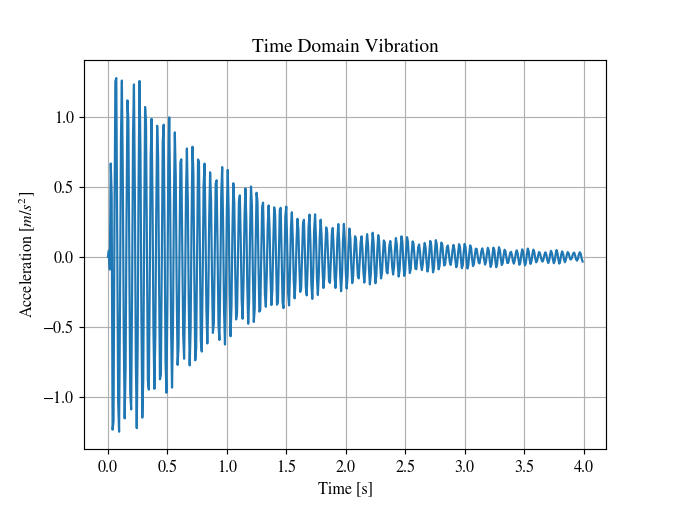

In [4]:
acel_excel = pd.read_excel(r'C:\Users\Ian\Desktop\Unifei\Engenharia Mecanica\Vibracoes Mecanicas\Laboratorio\Lab 1\resposta_no_tempo.xlsx', sheet_name = 'G2,1(f)_0.inputX(t)' , usecols = "B")
acel_sem_nan = acel_excel.dropna()
acel_np =  acel_sem_nan.to_numpy()
a = acel_np[1:]
a = a.ravel().tolist() # Para transformar em uma lista 1D (fft não funciona sem isso)
                                 
tempo_excel = pd.read_excel(r'C:\Users\Ian\Desktop\Unifei\Engenharia Mecanica\Vibracoes Mecanicas\Laboratorio\Lab 1\resposta_no_tempo.xlsx', sheet_name = 'G2,1(f)_0.inputX(t)' , usecols = "A")
tempo_sem_nan = tempo_excel.dropna()
tempo_np =  tempo_sem_nan.to_numpy()
t = tempo_np[1:]
t = t.ravel().tolist()

fig, ax = plt.subplots()
ax.plot(t,a)
ax.set(xlabel='Time [s]', ylabel = 'Acceleration $[m/s^2]$', title = 'Time Domain Vibration')
plt.show()
ax.grid()

### Fast Fourier Transform

A FFT é usada para obter a reposta do sinal no domínio da frequência. Onde há uma grande amplitude indica a frequência em que a estrutura está vibrando.

<IPython.core.display.Javascript object>


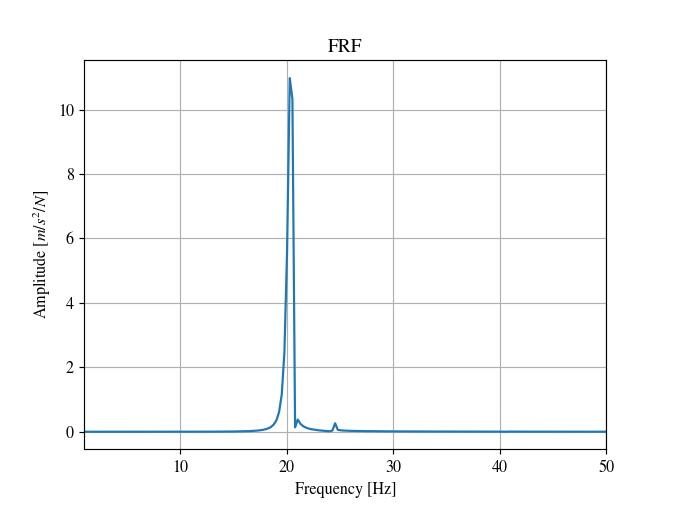

C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [13]:
n = len(t)
dt = max(t)/n

a_fft = np.fft.fft(a,n)            # Compute the FFT
a_PSD = a_fft*np.conj(a_fft)/n     # Power Spectrum (magnitude of each fft coef. squared)
freq = (1/(dt*n)*np.arange(n))     # x-axis frquency
L = np.arange(1,np.floor(n/2),dtype='int')

fig, ax = plt.subplots()
ax.plot(freq[L],a_PSD[L])
ax.set(title='FRF',xlabel='Frequency [Hz]',ylabel='Amplitude [$m/s^2/N$]')
plt.xlim(L[0],50)
ax.grid()

## Frequency Response Function

A FRF é dada pela divisão da resposta pelo input no domínio da frequência.

Então não tenho os dados do input, vou só importar o resultado

<IPython.core.display.Javascript object>


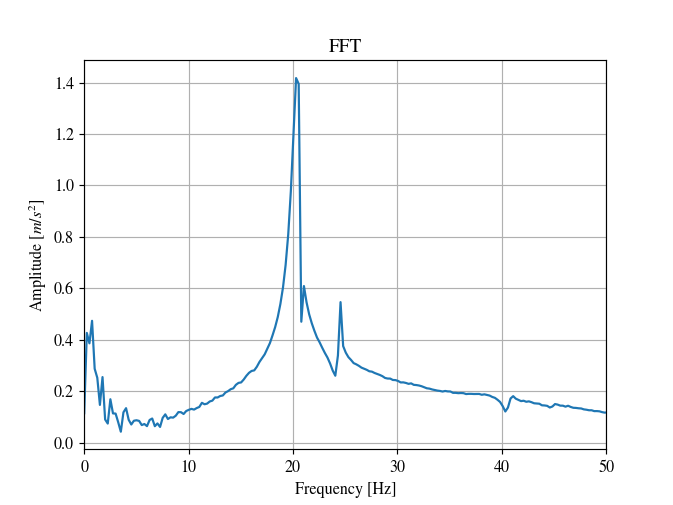

In [12]:
FRF_excel = pd.read_excel(r'C:\Users\Ian\Desktop\Unifei\Engenharia Mecanica\Vibracoes Mecanicas\Laboratorio\Lab 1\fft.xlsx', sheet_name = 'G2,1(f)_0.GX,X(f)' , usecols = "B")
FRF_sem_nan = FRF_excel.dropna()
FRF_np =  FRF_sem_nan.to_numpy()
a_FRF = FRF_np[1:]

n_FRF = len(a_FRF)
dt_FRF = max(t)/n_FRF

freq_FRF = (1/(dt_FRF*n_FRF)*np.arange(n_FRF))

fig, ax = plt.subplots()
ax.plot(freq_FRF,a_FRF)
ax.set(title='FFT',xlabel='Frequency [Hz]',ylabel='Amplitude [$m/s^2$]')
plt.xlim(0,50)
ax.grid()

## Técnica do Decremento Logarítimico
Essa técnica é usada para obter os parâmetros de amortecimento do sistema. A equação para obter o $\delta$ é 

$ \delta = \frac{1}{n}ln(\frac{y_i}{y_{i+n}})$

Onde $n$ é o o número de ciclos passados.

Com o valor de $\delta$ é possível calcular o fator de amortecimento $\zeta$ conforme a equação a seguir.

$\zeta = \frac{\delta}{\sqrt{(2\pi)^2+\delta^2}}$

In [7]:
a_picos = []
t_picos = []

for i in range(len(a)):
    if a[i] > a[i-1] and a[i] > a[i+1]:
        a_picos.append(a[i])
        t_picos.append(t[i])    

ciclos = 3
delta = 1/ciclos*np.log(a_picos[10]/a_picos[10+ciclos])

zeta = delta/np.sqrt((2*np.pi)**2+delta**2)

freq_nat = freq[a_PSD.argmax()]

freq_amort = np.sqrt(1-zeta**2)*freq_nat



print('delta: ', delta)
print('Fator de Amortecimento: ', zeta)
print('Frequência Natural [Hz]: ', freq_nat)
print('Frequência de Amortecimento [Hz]: ', freq_amort)


delta:  0.10116020290516133
Fator de Amortecimento:  0.016098060044726567
Frequência Natural [Hz]:  20.289628180039138
Frequência de Amortecimento [Hz]:  20.286999006105297


#### Modelagem Teórica

<IPython.core.display.Javascript object>


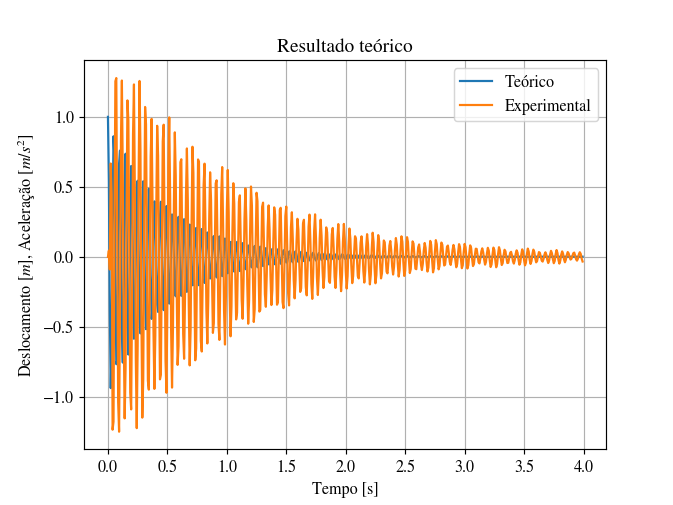

In [8]:
x0 = 1
dx0 = 0

C1 = x0
C2 = (dx0+zeta*freq_nat*x0)/freq_amort
X = np.sqrt(C1**2+C2**2)
phi = np.arctan(C1/C2)

freq_amort_rad = freq_amort*2*np.pi
freq_nat_rad = freq_nat*2*np.pi


x_t = []
for i in t:
    x = X*np.exp(-zeta*freq_nat_rad*i)*np.sin(freq_amort_rad*i + phi)
    x_t.append(x)

fig, ax = plt.subplots()
ax.plot(t,x_t)
ax.set(title='Resultado teórico',xlabel='Tempo [s]',ylabel='Deslocamento [$m$], Aceleração [$m/s^2$]')
ax.plot(t,a)
ax.legend(['Teórico','Experimental'])
ax.grid()

#### Determinando as constantes dinâmicas do sistema
Considerando o esquema a seguir, 
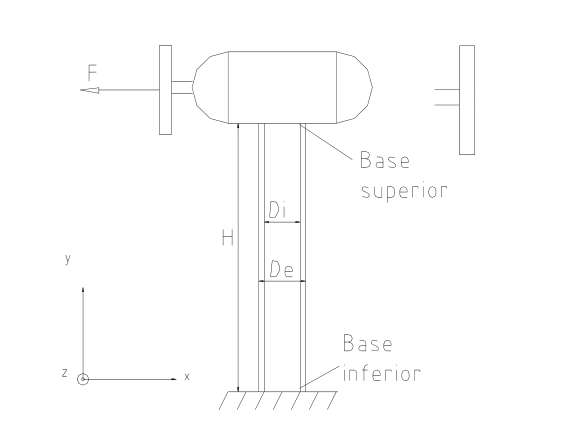

Temos que m1 = m_mot, m2 = m_tub, L1 = H e L2= H/2. 

Pelo método da energia, temos que a massa equivalente do sistema é dada por

$ 1/2m_1\dot{x_1}^2 + 1/2m_2 \dot{x_2}^2 = 1/2m_{eq} \dot{x_{eq}}^2 $

Como

$ x_2 = x_1\frac{L_2}{L_1} $

$ m_{eq} = m_1+0.23m_2  $

In [9]:
m1 = 10.67
m2 = 6.29
L1 = 0.868
L2 = L1/2

m_eq = m1+0.23*m2

print('Massa Equivalente [kg]: ', m_eq)

Massa Equivalente [kg]:  12.1167


A frequência natural é dada por 

$ \omega_n = \sqrt{k/m}$

Assim

$k= \omega_n^2 m$

In [10]:
k = freq_nat_rad**2*m_eq
print('Rigidez do sistema [N/m]: ', k)

Rigidez do sistema [N/m]:  196921.10709966518


O amortecimento é dado por

$ c = 2\zeta\omega_n m $

In [11]:
c = 2*zeta*freq_nat_rad*m_eq
print('Constante de amortecimento [Ns/m]: ', c)

Constante de amortecimento [Ns/m]:  49.732678559880455
